#### **Introduction**

At the end of the year, each Spotify user will get the Spotify Wrapped, including the playlist, for example, "Your Top Songs 2023" showing the top 100 songs you were listening the most in 2023. The playlist is calculated merely based on the play count, that means they are 100 songs you made the most play counts in the year.

I understand that method. It is intuitive, but I wonder if there is another logical method to create a similar playlist. Then I came up with an idea: the playlist of the songs you played repeatedly the most.

**Let's define some basic terms**
- A __*replayed  song*__ is a song that are played repeatedly, not interrupted by another song.

    *For example, here is my Spotify streaming history in a working day. The replayed songs were A and D. The songs such as B, C, E, F were not replayed.*

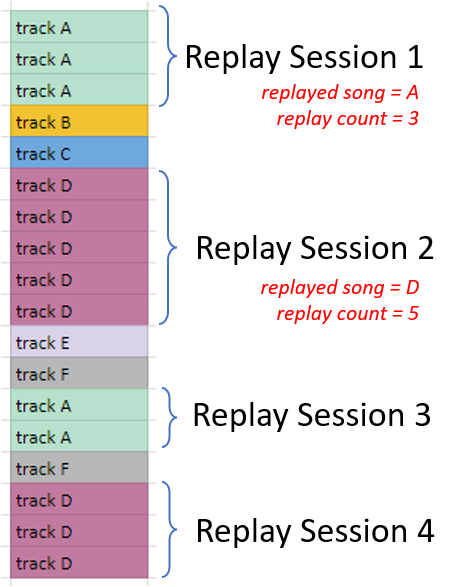


- A __*replay session*__ contains a unique song that got replayed. A replay session starts when I starts to replay that song, and end when I move on the other song.

    *In the above example, I had 4 replay sessions, 2 for song A, 2 for song D.*

- __*Replay count*__ is the number of times a song is replayed in a replay session.

    *In the first session, the replay count of song A is 3.*

**Why am I interested in songs that got replayed?**

- You won't replay a song that you don't like, do you?
- If you repeatedly played a song, i.e. for 10, 20 times consecutively, it would highly be a song you love, at least for that short period of time.
- I know that a lot of people have the habit of binge listening when they find a song they like. They keep playing that song, again and again, maybe until they become bored with the song. The replay sessions they made with the song might not help the song to be included in the Spotify "Your Top Songs" but the song probably says something about them, thus it should not be ignored.

The playlist "Your Replayed songs" will contain the songs that you like or at least, you used to like. In other words, a playlist of the songs you are binge listening or used to be binge listening. I believe it's worth listening to them again.

In this article, I will use my personal streaming history. The time range is "all time" - since I started to use Spotify.



In [1]:
import pandas as pd
import json
import re
from datetime import datetime
import pytz
import glob
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import scipy
from pandasql import sqldf

#### **Questions I'll find the answer**

1. How many songs that are 'replayed songs'? And distribution of the replay count?
2. TOP 30 songs that have the most replay counts
3. TOP 30 songs that have the most replay sessions
4. TOP replay songs by merging two above lists
5. TOP 10 artists has the most replay songs
6. In which part of the day I would highly replay a song?
7. TOP 10 longest replay sessions

#### **Step 1: Raw file merging**

After I make a request for the all-time streaming history, I received a link to download the history file (in json type). My streaming history is divided into a few json files, so I need to merge them into a single file.

I'll use python built-in module "glob" to search for the json files based on the pattern of the names.

In [9]:
merged_json = []
for jsonFile in glob.glob('streaming_history\*.json'): # search for all json files from the directory
    with open(jsonFile, 'rb') as file: 
        x = json.load(file)
        merged_json+= x

to_json_file = json.dumps(merged_json) # convert merged_json to a json type object, so that we can convert it into a dataframe
df = pd.read_json(to_json_file) # now we have the dataframe we need

#### **Step 2: Data Transformation**

After the dataframe has been created, we need to clean it. This is the part I always love.
Explanation for each column:
- ts: This field is a timestamp indicating when the track stopped playing in UTC (Coordinated Universal Time). The order is year, month and day followed by a timestamp in military time.
- platform: This field is the platform used when streaming the track (e.g. Android OS, Google Chromecast).
- ms_played: This field is the number of milliseconds the stream was played
- master_metadata_track _name: This field is the name of the track.
- master_metadata_album_artist_name: This field is the name of the artist, band or podcast.
- master_metadata_album_album_name: This field is the name of the album of the track.
- spotify_track_uri: A Spotify URI, uniquely identifying the track in the form of “spotify:track:<base-62 string>”
- reason_start: This field is a value telling why the track started (e.g. “trackdone”)
- reason_end: This field is a value telling why the track ended (e.g. “endplay”).
- shuffle: This field has the value True or False depending on if shuffle mode was used when playing the track.
- skipped: This field indicates if the user skipped to the next song
- offline: This field indicates whether the track was played in offline mode (“True”) or not (“False”).


**Step 2.1: Choose columns to keep**

a) Choose columns to keep

In [3]:
for i, name in enumerate(df.columns):
    print(f"{i} ---> {name}")

In [4]:
keep_col = [0,3,7,8,9,10] # Columns to keep
df = df.iloc[:, keep_col]

IndexError: positional indexers are out-of-bounds

b) Rename the columns

In [ ]:
df = df.rename(columns={
    'master_metadata_track_name': 'track_name',
    'master_metadata_album_artist_name': 'artist_name',
    'master_metadata_album_album_name': 'album_name'
})

**Step 2.2: Look at null values and drop them if necessary**

In [ ]:
# check for the null values
df.isnull().sum()

ts                      0
ms_played               0
track_name           1532
artist_name          1532
album_name           1532
spotify_track_uri    1532
dtype: int64

In [ ]:
# keep the row where track_name is not null
df = df[df['track_name'].notna()]

**Step 2.3: Sort the table by the timestamp column then reset the index**

In [ ]:
# Change the timestamp from Zulu time to GMT+7
df['timestamp'] = pd.to_datetime(df['ts'])
df['timestamp'] = df['timestamp'].dt.tz_convert('Asia/Ho_Chi_Minh')
df['date'] = df['timestamp'].dt.date
df['time'] = df['timestamp'].dt.time

df = df.drop(['ts'], axis=1) # drop the 'ts' column

df = df.sort_values(by='timestamp', ascending=True, ignore_index=True)

#### **Step 3: Aggregate the data**


The aggregation is sometimes easier to conduct with SQL rather than Python, but Python provides us flexibility. It's really worth learning and practicing this progamming language.

Now I'll detect the replay sessions.

In [ ]:
df['next_track'] = df['spotify_track_uri'].shift(-1)

df['will_be_replay'] = np.select(
    [df['spotify_track_uri'] == df['next_track']],
    [True]
)


In [ ]:
x = 0 # running variable số lần replay thứ bao nhiêu
result = [] # đánh số thứ tự lần thứ bao nhiêu replay

ses = 1 # running variable số thứ tự của replay session
session = [] # list chứa running variable số thứ tự của replay session


for i in df.index:
    c = df.will_be_replay[i]
    if i == 0:
        p1 = 0
    else:
        p1 = df.will_be_replay[i-1]

    if c == 0 and p1 == 0:
        x = 0
        result.append(x)
    elif p1 == 1:
        x += 1
        result.append(x)
    elif c == 1 and p1 == 0:
        x = 1
        result.append(x)
    
    

df['cummulative_replay'] = pd.Series(result)

for j in df.index:
    c = df.will_be_replay[j]
    if j == 0:
        p1 = 0
    elif j > 0:
        p1 = df.will_be_replay[j-1]

    if c == 0 and p1 == 0:
        session.append(np.nan)
    elif c == 1 and p1 == 0:
        ses += 1
        session.append(ses)
    else:
        session.append(ses)



df['replay_session'] = pd.Series(session)

Until this, we have found the replay sessions. We'll create the pivot table to calculate: 

| Column name | Explanation | Example |
| --- | --- | --- |
| start_time | When the session begins (in HH:mm:ss) | I started to replay "Happy New Year" by ABBA from 16:44:47 |
| start_date | When the session begins (in YYYY-MM-DD) | The session began in 2016-12-10 |
| start_weekday | The weekday of the start_date | The session began in Saturday |
| replay_count | How many times the song are replayed in the session | I would play this song 30 times consecutively before I played another song |
| duration |  How long the session will last (in HH:mm:ss) | The session of 30 times playing "Happy New Year" last for 92 minutes, 23 seconds |


In [ ]:
replay = pd.pivot_table(
    data = df.loc[:, ['track_name', 'artist_name', 'album_name','spotify_track_uri', 'replay_session', 'cummulative_replay', 'timestamp', 'ms_played']],
    index = ['track_name', 'artist_name', 'album_name','spotify_track_uri', 'replay_session'],
    values = ['timestamp','cummulative_replay', 'ms_played'],
    aggfunc= {'timestamp': 'min', 'cummulative_replay': 'max', 'ms_played': 'sum'}
)

replay.columns = ['replay_count', 'duration', 'start_timestamp'] # rename the calculated columns
replay['duration'] = pd.to_datetime(replay['duration'], unit='ms').dt.strftime('%H:%M:%S') # convert the duration of session in the format of HH:mm:ss
replay = replay.reset_index()

replay['start_date'] = replay['start_timestamp'].dt.date
replay['start_time'] = replay['start_timestamp'].dt.time
replay['start_hour'] = replay['start_timestamp'].dt.hour
replay['start_weekday'] = replay['start_timestamp'].dt.strftime('%A')
replay = replay.drop(['start_timestamp'], axis=1)

Because a song can be unwillingly replayed for some reasons, I will only consider the replay session with the replay count >= 3.

In [ ]:
replay = replay[replay.replay_count >= 3].reset_index(drop=True)

1. How many songs were replayed?
2. TOP 50 songs that got replayed most
3. TOP 10 songs that have the most replay sessions
4. In what part of the day I would highly replay a song?
5. In which day of the week I would highly replay a song?
6. TOP 10 longest replay sessions

#### **Step 4: Answer the questions**

**1. How many songs that are 'replayed songs'? And distribution of the replay count?**

In [ ]:
replay.replay_count.describe().reset_index()

,index,replay_count
0,count,886.000000
1,mean,9.147856
2,std,20.716042
3,min,3.000000
4,25%,3.000000
5,50%,4.000000
6,75%,8.000000
7,max,520.000000


In [ ]:
# count distinct song_id
len(replay.spotify_track_uri.unique())

637

Since I started to use Spotify (excluding the sessions with the replay count <= 2):
- I had 886 replay sessions. 
- Max replay count of a session = 520 (wow!!!)
- There are 637 unique songs appearing in a replay session. (wow!!)

The distribution of replay count is highly right-skewed, thus the mean value of replay count (which is 9.14) is not valuable.

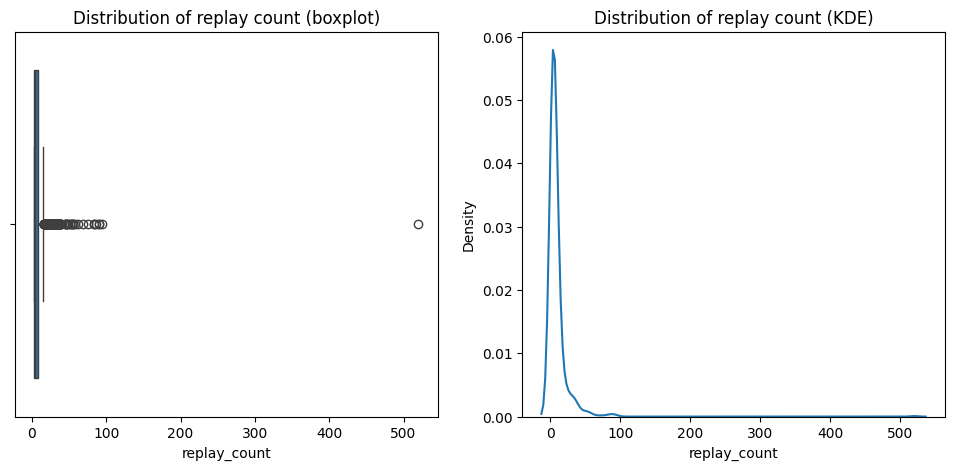

In [ ]:
fig, (ax1, ax2)= plt.subplots(1,2, figsize=(12,5))
ax1 = sns.boxplot(
    replay.replay_count,
    ax = ax1,
    orient='h'
)
# ax1.set_yticks(np.arange(0,600,50))
ax1.set_title('Distribution of replay count (boxplot)')

sns.kdeplot(
    replay.replay_count,
    ax = ax2
)
ax2.set_title('Distribution of replay count (KDE)')
plt.show()

Because we don't have a lot of distinct values for replay_count, we should look at all the values to see the distribution.

In [ ]:
replay.replay_count.value_counts().reset_index().sort_values(by='replay_count')

What can we tell? The highest occurence is of course 3. The number of replay count in a session is often below 16.  Replay count above 25 is quite rare. There is only one single session with replay count above 100, and surprisingly, I replayed a song 520 times in that session.

Let's look at that 520-session.

In [ ]:
replay[replay.replay_count == 520]

,index,track_name,artist_name,album_name,spotify_track_uri,replay_session,replay_count,duration,start_timestamp,start_date,start_time,start_weekday
48,199,Alone At Last,mellow fox,Take A Break,spotify:track:2nOnnz6eVIR9WaehoRbNwS,3919.0,520,09:05:36,2023-08-02 09:00:38+07:00,2023-08-02,09:00:38,Wednesday


It happened recently, on 2023-08-02. It was a normal working day. I replayed the song since the start of working hour (9:00) till I got home (18:05). Just a song, for the entire day. 

And guess what, 520 times playing consecutively didn't help the song to be in my "Your Top Songs 2023" created by Spotify.

**2. TOP 30 songs that have the most replay counts**

First I'll create the table 'groupby_song', then it's easy to filter the top songs by total_replay_count or no_session.

In [ ]:
groupby_song = pd.pivot_table(
    data=replay.loc[:, ['spotify_track_uri', 'track_name', 'artist_name','replay_session','replay_count']],
    index = ['spotify_track_uri', 'track_name', 'artist_name'],
    values= ['replay_session','replay_count'],
    aggfunc= {'replay_session': 'count','replay_count': 'sum'}
)

groupby_song.columns = ['total_replay_count', 'no_session']
groupby_song = groupby_song.reset_index()

,spotify_track_uri,track_name,artist_name,total_replay_count,no_session
0,spotify:track:00fbABFSx3C0IGbBZwZ6my,After the Afterparty - Acoustic,Charli XCX,9,1
1,spotify:track:02KOC3fs7e7lBLeU9bCfE9,20 On 10 Off Workout Beat - Loop,Workout Music Coach,19,1
2,spotify:track:02Ktx2GZoOqrNrxc1boPgh,Hotline Bling (Acoustic Piano and Guitar Version),Michael Claudio,3,1
3,spotify:track:03yc0G2OoH1Eeyu7Piy8fK,I'm Yours,Jason Mraz,4,1
4,spotify:track:046BmJVCt4qOFnEGK7CZJK,Phố Đã Lên Đèn,Huyền Tâm Môn,3,1
...,...,...,...,...,...
632,spotify:track:7xEX406hnVXC7mDfkts2jc,Interstellar Main Theme - Piano Version,Patrik Pietschmann,7,1
633,spotify:track:7yR48NM3Bg5qoTfN9bWmyP,Ngàn Điều Ước Cho Em,Tuấn Hưng,3,1
634,spotify:track:7zPOzPNCIekQQvGWRqM2DH,Khi Cô Đơn Em Nhớ Ai,Đan Trường,9,1
635,spotify:track:7zaiLgzejyT5M7fTsmqZ18,Dream a Little Dream,Pink Martini,5,1


In [ ]:
top30_replaycount = groupby_song.sort_values(by='total_replay_count', ascending=False, ignore_index=True).head(30)

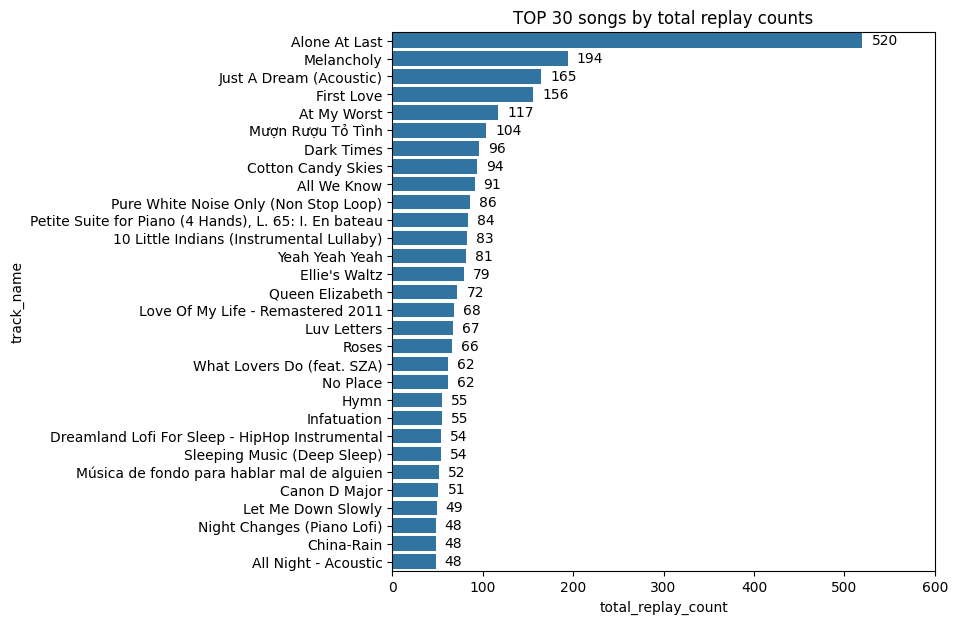

In [ ]:
ax = sns.barplot(
    data = top30_replaycount,
    y = 'track_name',
    x = 'total_replay_count'
)
# change figsize
fig = plt.gcf()
fig.set_size_inches(7,7)

# set title and change xticks
ax.set_xticks(np.arange(0,top30_replaycount.total_replay_count.max() + 100,100))
ax.set_title('TOP 30 songs by total replay counts')

# add data table
name = top30_replaycount.track_name
value = top30_replaycount.total_replay_count

for i in range(len(top30_replaycount)):
    plt.text(value[i] + 10, name[i], value[i], va = 'center')
plt.show()

**3. TOP 30 songs that have the most replay sessions**

In [ ]:
top30_no_session = groupby_song.sort_values(by=['no_session', 'total_replay_count'], ascending=False, ignore_index=True).head(30)

C:\Users\minh.tl\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 21345 (\N{CJK UNIFIED IDEOGRAPH-5361}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\minh.tl\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 36786 (\N{CJK UNIFIED IDEOGRAPH-8FB2}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\minh.tl\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 37628 (\N{CJK UNIFIED IDEOGRAPH-92FC}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\minh.tl\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 29748 (\N{CJK UNIFIED IDEOGRAPH-7434}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\minh.tl\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:152: UserWarning:

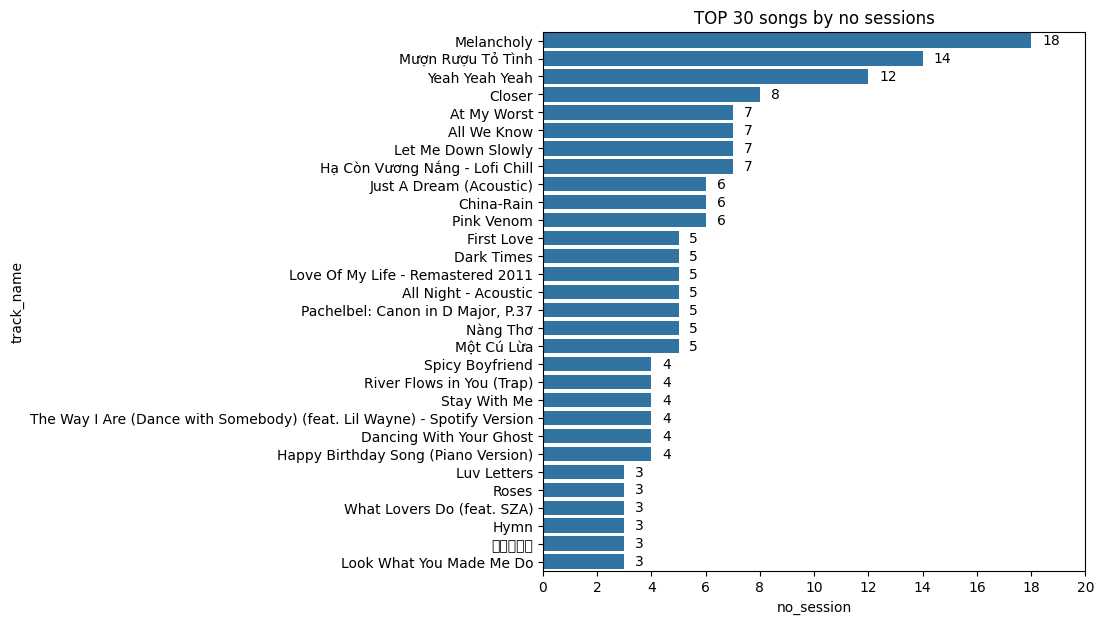

In [ ]:
ax = sns.barplot(
    data = top30_no_session,
    y = 'track_name',
    x = 'no_session'
)
# change figsize
fig = plt.gcf()
fig.set_size_inches(7,7)

# set title and change xticks
ax.set_xticks(np.arange(0,top30_no_session.no_session.max() + 3,2))
ax.set_title('TOP 30 songs by no sessions')

# add data label
name = top30_no_session.track_name
value = top30_no_session.no_session

for i in range(len(top30_no_session)):
    plt.text(value[i] + 0.4, name[i], value[i], va = 'center')
plt.show()

**4. TOP replay songs by merging two above lists**

In [ ]:
top_replay_song = pd.concat([top30_replaycount, top30_no_session]).drop_duplicates().reset_index().drop(['index'], axis=1)

**5. TOP 5 artists has the most replay songs**

Based on the table: groupby_song

In [ ]:
pd.set_option('display.max_colwidth', None)
groupby_artist = pd.pivot_table(
    data= groupby_song.loc[:, ['artist_name', 'spotify_track_uri', 'track_name', 'no_session', 'total_replay_count']],
    index = ['artist_name'],
    values = ['spotify_track_uri','no_session', 'total_replay_count', 'track_name'],
    aggfunc = {'spotify_track_uri': 'nunique', 'no_session': 'sum', 'total_replay_count':'sum','track_name': lambda x: ' | '.join(x)}
)
groupby_artist.columns = ['no_session', 'no_tracks', 'total_replay_count', 'track_list'] # change the column names
groupby_artist = groupby_artist.reindex(['no_tracks', 'no_session', 'total_replay_count','track_list'], axis=1).reset_index() # re-order the columns
top_artists = groupby_artist.sort_values(by='no_tracks', ascending=False, ignore_index=True).head(10) # LIMIT 10
top_artists

,artist_name,no_tracks,no_session,total_replay_count,track_list
0,Đen,7,11,48,Lối Nhỏ | Lối Nhỏ | Rapcoustic 5 | Bài Này Chill Phết | Trốn Tìm | Mang Tiền Về Cho Mẹ | Luôn yêu đời
1,Guus Dielissen,6,6,92,Dance Monkey (Instrumental Guitar) | Canon In D - Guitar Version | Dance Monkey (Instrumental Guitar) | Canon In D - Guitar Version | River Flows In You - Guitar Version | My Heart Will Go On - Acoustic Instrumental
2,Sasha Alex Sloan,6,9,53,Matter To You | Dancing With Your Ghost | Dancing With Your Ghost | Older | when was it over? (feat. Sam Hunt) | Runaway
3,Queen,6,10,85,Love Of My Life | Love Of My Life - Remastered 2011 | Somebody To Love - Remastered 2011 | Bohemian Rhapsody - Remastered 2011 | We Will Rock You - Remastered 2011 | Crazy Little Thing Called Love - Remastered 2011
4,Sungha Jung,6,7,56,River Flows In You | I'm Yours | Wake Me up When September Ends | Etude | May Be | Is There Still Anything That Love Can Do?
5,Karmin,6,6,66,Sleigh Ride | Sugar | Save Me Now | I Got You | Along The Road | Didn't Know You
6,The Chainsmokers,4,19,207,All We Know | Roses | Closer | Inside Out
7,Akon,4,5,19,Don't Matter | Lonely | Blown Away | Lonely
8,Music Travel Love,4,6,26,You Are My Sunshine | I Don't Want to Miss a Thing | True Colors (Live at Singha Park) | One More Day
9,Taylor Swift,4,7,51,champagne problems | Look What You Made Me Do | A Place In This World | 22


**6. In which part of the day I would highly replay a song?**

Let's count the replay session by the start hour.

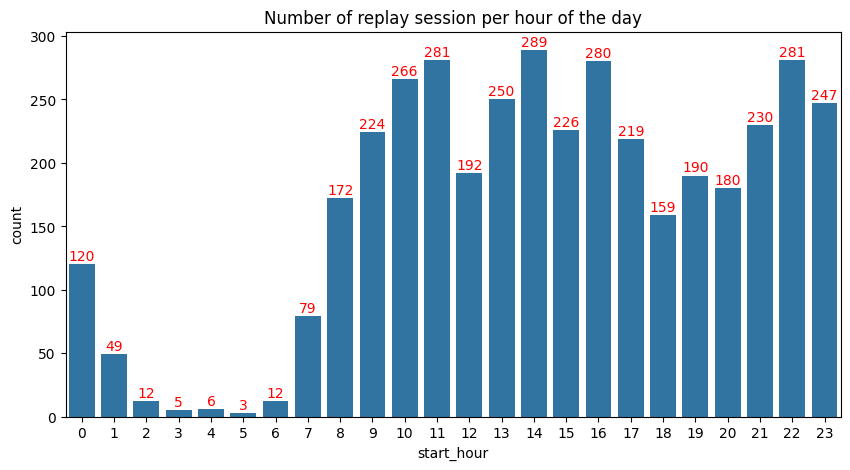

In [ ]:
ax = sns.countplot(
    replay,
    x = 'start_hour'
)
ax.set_title('Number of replay session per hour of the day')
fig = plt.gcf()
fig.set_size_inches(10,5)

# add data label
for x, y in zip(replay.start_hour.value_counts().sort_index().index, replay.start_hour.value_counts().sort_index().values):
    plt.text(x, y + 3, y, ha = 'center', c = 'r')

Can't believe I had some replay sessions from 1AM to 6AM. The sessions occured through out the day but they are less often when the hour is 7, 12, 18, 19, 20.

**7. TOP 10 longest replay sessions**

In [ ]:
replay.sort_values(by='duration', ascending=False).head(15).reset_index(drop=True)

,track_name,artist_name,album_name,spotify_track_uri,replay_session,replay_count,duration,start_date,start_time,start_hour,start_weekday
0,Alone At Last,mellow fox,Take A Break,spotify:track:2nOnnz6eVIR9WaehoRbNwS,3919.0,520,09:05:36,2023-08-02,09:00:38,9,Wednesday
1,"Petite Suite for Piano (4 Hands), L. 65: I. En bateau",Claude Debussy,Debussy for a Winter's Night,spotify:track:09VUSf4trKhWcaCLoaFEjn,3262.0,84,05:05:47,2021-12-11,09:25:08,9,Saturday
2,Ellie's Waltz,Pete Huttlinger,McGuire's Landing,spotify:track:2EWOa4JwI2GMdUfjIumzoX,87.0,75,04:15:47,2016-12-20,09:59:23,9,Tuesday
3,At My Worst,Andrew Foy,At My Worst,spotify:track:3jMS87turh5ccrz88ub9Lg,2729.0,91,04:14:42,2021-04-02,13:41:34,13,Friday
4,Queen Elizabeth,Cheat Codes,Queen Elizabeth,spotify:track:7AsRAjp13OTva5JdDWCBn1,69.0,69,03:47:48,2016-11-17,09:02:46,9,Thursday
5,Just A Dream (Acoustic),Jason Chen,Just A Dream (Acoustic),spotify:track:5eAtlkhV8Z6Kl1QvBPn32o,2512.0,90,03:43:31,2021-02-17,11:04:51,11,Wednesday
6,Roses,The Chainsmokers,Roses,spotify:track:3vv9phIu6Y1vX3jcqaGz5Z,2466.0,58,03:35:39,2021-01-29,10:09:46,10,Friday
7,10 Little Indians (Instrumental Lullaby),Kimon Reve,Nursery Rhyme Piano Lullabies,spotify:track:6L4hmRvRIA2HnbBp0f9AR5,3795.0,83,03:25:47,2023-04-07,13:41:22,13,Friday
8,Hai Mươi,Mỹ Tâm,"Mãi Yêu, Vol. 1",spotify:track:1QhxHoc32Psy5uw6ITjbiP,3463.0,47,03:15:05,2022-06-25,11:57:48,11,Saturday
9,Cotton Candy Skies,Esthie,Cotton Candy Skies,spotify:track:4yWCiMOk150jbE3NPuhXHu,3260.0,94,03:08:32,2021-12-09,15:41:12,15,Thursday


A replay session with > 30 play counts can last for > 2 hours. The sesion of 520 times playing "Alone At Last" last for 9 hours straight, equal the whole working day.